In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from IPython import display
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'

### K Means

In [2]:
data1 = sio.loadmat('data/kmeans2.mat')
x = data1['X']

In [3]:
def find_closest_centroids(x,centroids):
    x_expanded = np.expand_dims(x,axis=1)
    diff = np.sum((x_expanded - centroids)**2,axis=-1)
    ind = np.argmin(diff,axis=-1)
    return ind

def compute_centroids(x,ind,k):
    centroids=np.zeros((k,x.shape[1]))
    for i in range(k):
        centroids[i,:] = np.mean(x[np.where(ind==i)],axis=0)
    return centroids

def init_centroids(x,k):
    rand_ind = np.random.randint(low=0,high=x.shape[0],size=k)
    centroids = x[rand_ind]
    return centroids

In [4]:
#visualize
def visualize(x,centroids,ind, ax):
    _=sns.scatterplot(x[:,0],x[:,1],hue=ind,palette='viridis',legend=False,ax=ax)
    _=sns.scatterplot(centroids[:,0],centroids[:,1],marker='^', edgecolor='k', s=100, hue = np.arange(centroids.shape[0]),legend=False, palette='viridis',ax=ax)

In [5]:
def run_k_means(x,initial_centroids,max_iters,plot):
    centroids = initial_centroids
    k = initial_centroids.shape[0]
    ind = find_closest_centroids(x,initial_centroids)
    if plot:
        fig = plt.figure(figsize=(10,8))
        ax = plt.gca()
        visualize(x,centroids,ind,ax)
    for iter in range(max_iters):
        ind = find_closest_centroids(x,centroids)
        centroids = compute_centroids(x,ind,k)
        if plot:
            visualize(x,centroids,ind,ax)
            display.display(plt.gcf())
            time.sleep(1.0)
            display.clear_output(wait=True)
    return centroids

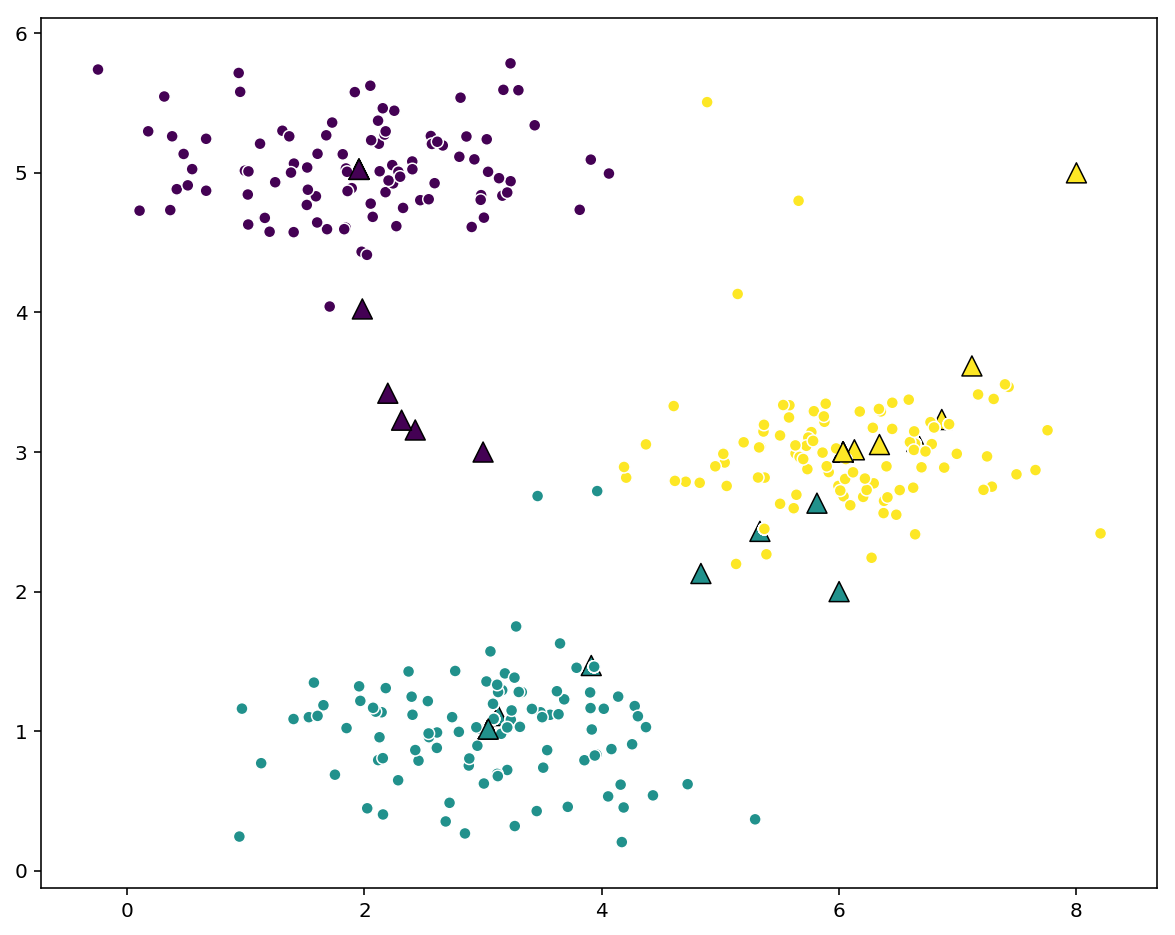

In [6]:
k = 3
initial_centroids = np.array([[3,3],[6,2],[8,5]])
max_iters=10
centroids = run_k_means(x,initial_centroids,max_iters,plot=True)

### Image Compression with K means

In [7]:
img = plt.imread('data/bird_small.png')
img_norm = img/255
x1 = np.reshape(img_norm,(img.shape[0]*img.shape[1],img.shape[2]))
k = 16
max_iters=10
initial_centroids = init_centroids(x1,k)
centroids = run_k_means(x1,initial_centroids,max_iters,False)
ind = find_closest_centroids(x1,centroids)
img_comp = np.reshape(centroids[ind],(img.shape[0],img.shape[1],img.shape[2]))*255

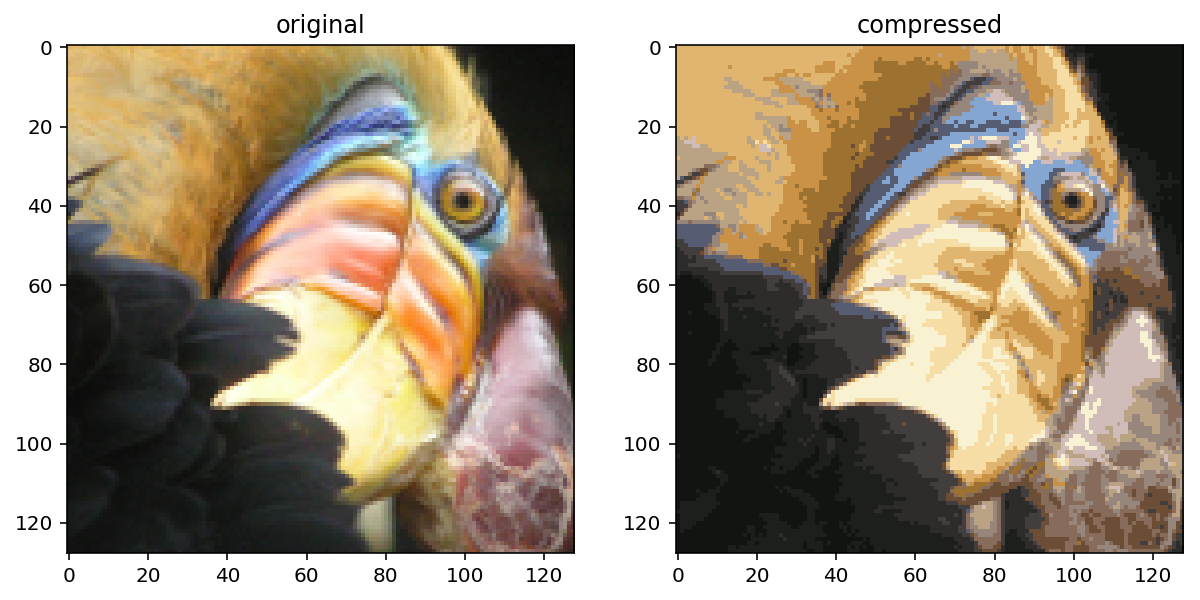

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,8))
_=axes[0].imshow(img)
_=axes[0].set_title('original')
_=axes[1].imshow(img_comp)
_=axes[1].set_title('compressed')

### PCA

In [9]:
def feature_normalize(x):
    mu = x.mean(axis=0)
    std = x.std(axis=0)
    x_norm = (x-mu)/std
    return (x_norm,mu,std)

def pca(x):
    cov = 1/x.shape[0] * np.dot(x.T,x)
    u,s,v = np.linalg.svd(cov)
    return (u,s)

def project(x,u,k):
    u_red = u[:,:k]
    z = np.dot(x,u_red)
    return z

def recover(z,u,k):
    u_red = u[:,:k]
    x_rec = np.dot(z,u_red.T)
    return x_rec

In [10]:
data2 = sio.loadmat('data/pca1.mat')
x2=data2['X']
x2_norm,mu,std = feature_normalize(x2)
u,s = pca(x2_norm)

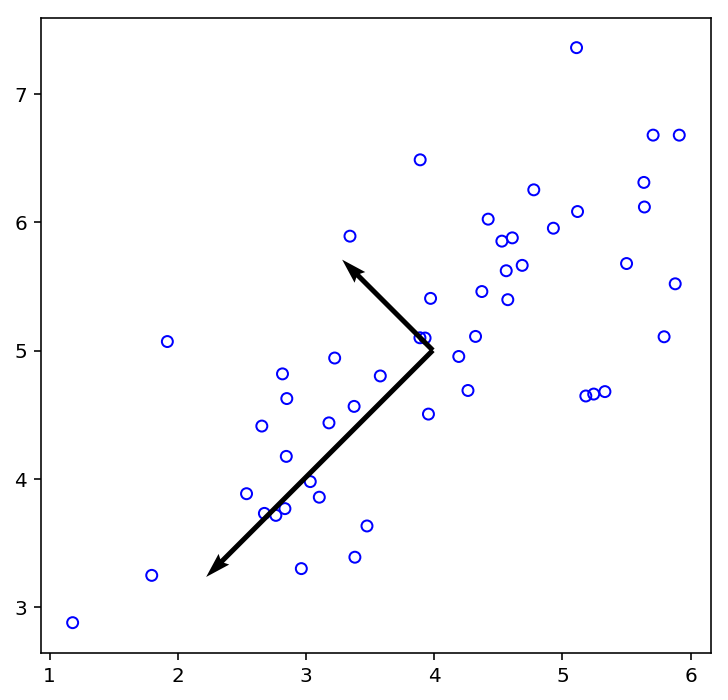

In [11]:
figure = plt.figure(figsize=(6,6))
plt.scatter(x2[:,0], x2[:,1], s=30, edgecolors='b',facecolors='None', linewidth=1)
plt.gca().set_aspect('equal')
plt.quiver(mu[0], mu[1], u[0,0], u[1,0], scale_units='xy', scale = 0.4, color='k')
plt.quiver(mu[0], mu[1], u[0,1], u[1,1], scale_units='xy', scale = 1, color='k');

In [12]:
k=1
z = project(x2_norm,u,k)
x2_rec = recover(z,u,k)

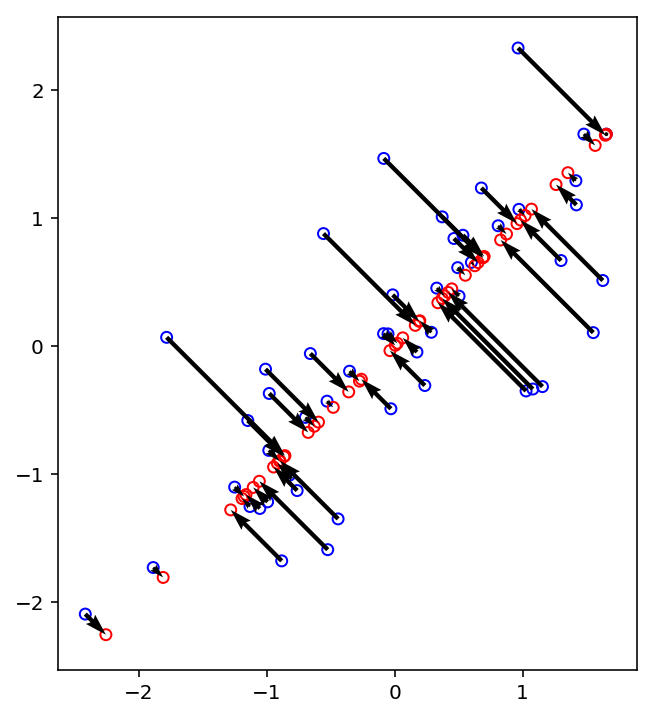

In [13]:
figure = plt.figure(figsize=(6,6))
plt.scatter(x2_norm[:,0], x2_norm[:,1], s=30, edgecolors='b',facecolors='None', linewidth=1)
plt.gca().set_aspect('equal')
_=plt.scatter(x2_rec[:,0],x2_rec[:,1],s=30,edgecolors='r',facecolors='None',linewidth=1)
_=plt.quiver(x2_norm[:,0],x2_norm[:,1],x2_rec[:,0]-x2_norm[:,0],x2_rec[:,1]-x2_norm[:,1],scale_units='xy',scale=1,linewidth=1,linestyle='dashed')

In [14]:
data3 = sio.loadmat('data/faces.mat')
x3 = data3['X']

In [15]:
def visualize_faces(x,n):
    fig, axes = plt.subplots(nrows=n,ncols=n,figsize=(10,10))
    plt.subplots_adjust(wspace=0.025,hspace=0.025)
    for i, ax in enumerate(axes.flatten()):
        img = np.reshape(x[i],(32,32))
        img = img.T
        ax.imshow(img,cmap='gray')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

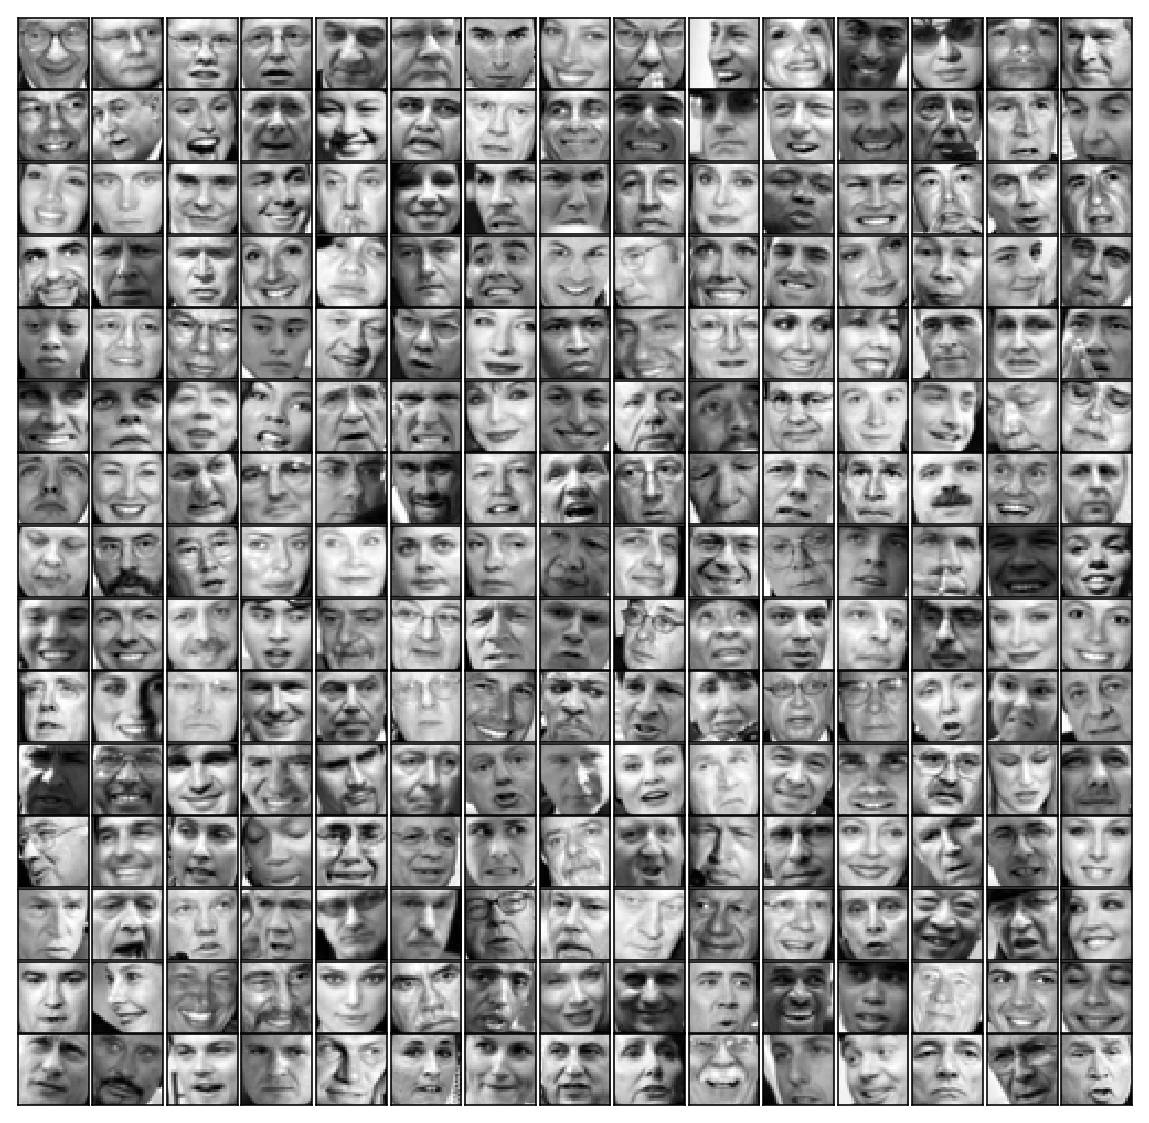

In [16]:
#visualize original images
visualize_faces(x3,15)

In [17]:
x3_norm, mu, sigma = feature_normalize(x3)
u,s= pca(x3_norm)

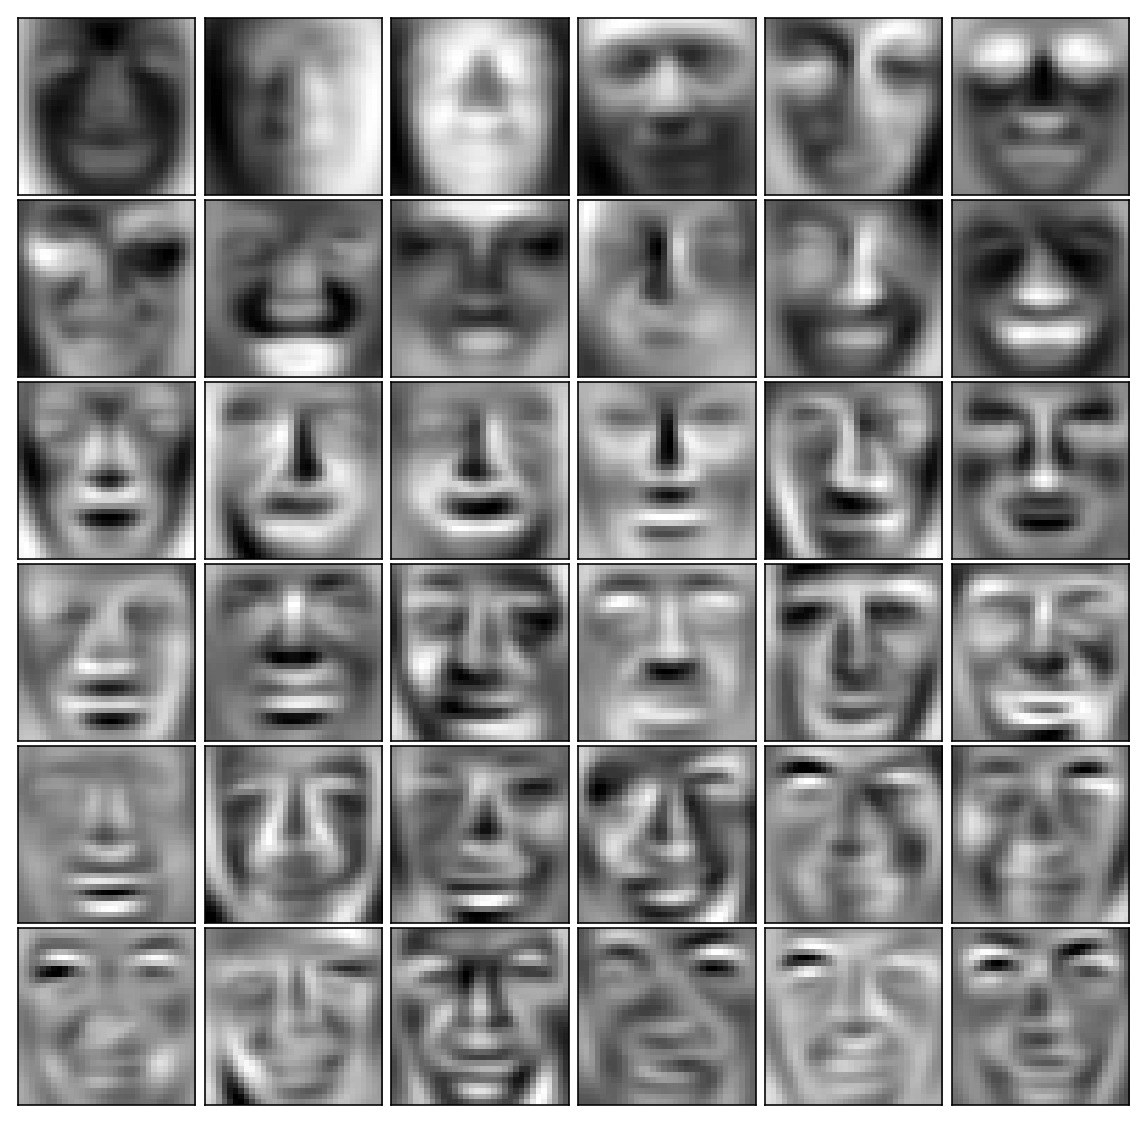

In [18]:
#visualize principal components
visualize_faces(u.T,6)

In [19]:
k = 100
z = project(x3_norm,u,k)
x3_rec = recover(z,u,k)

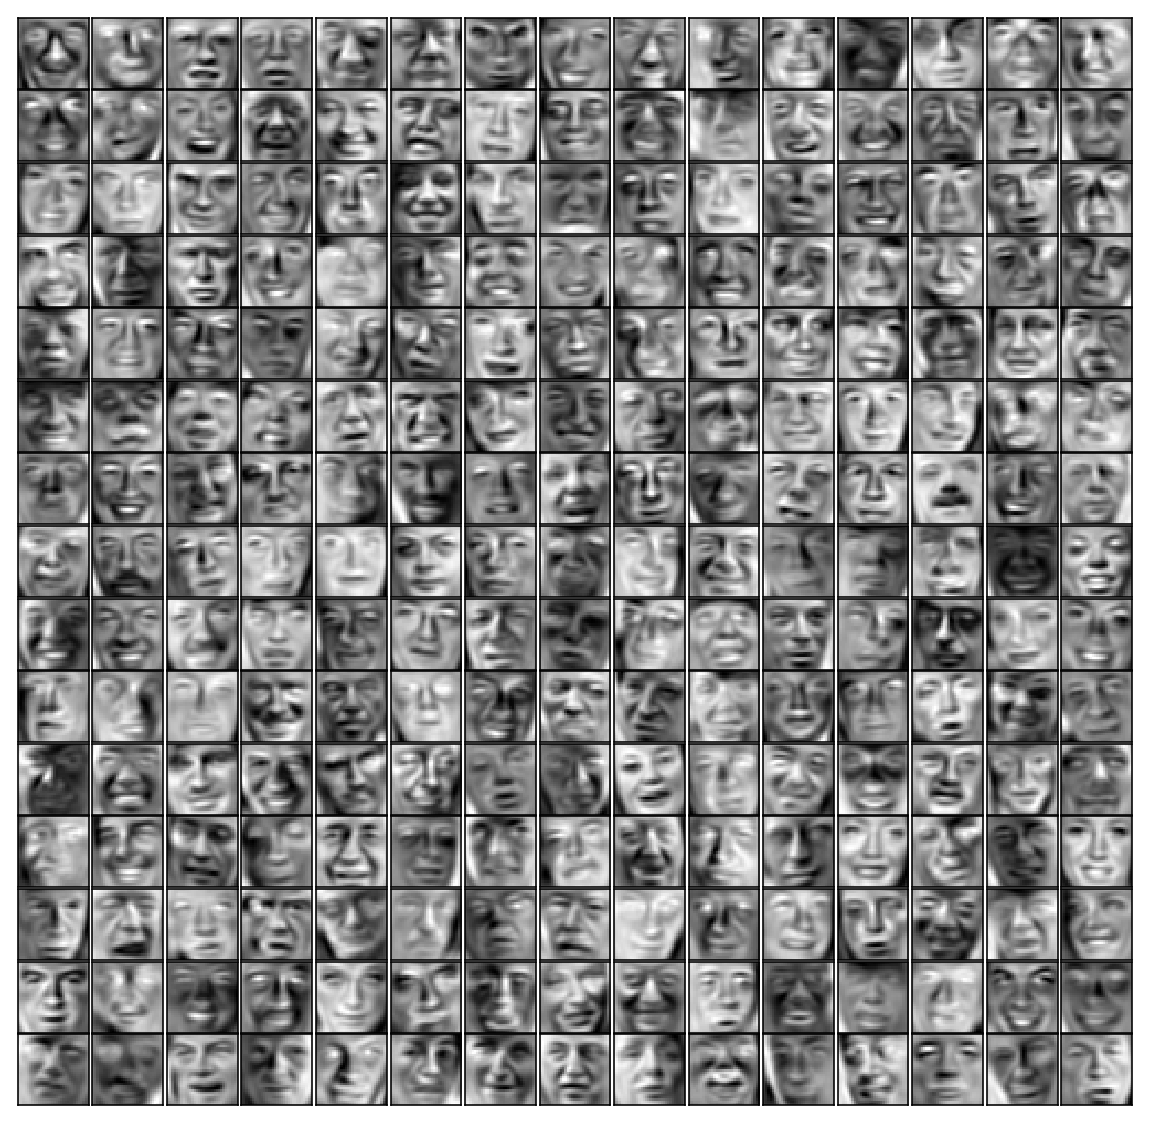

In [20]:
#visualize recovered images
visualize_faces(x3_rec,15)

#### PCA for visualization

In [21]:
#plotting original data
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

rand_ind = np.random.randint(0,x1.shape[0],1000,dtype='int')
trace1 = go.Scatter3d(
    x=x1[rand_ind,0]*255,
    y=x1[rand_ind,1]*255,
    z=x1[rand_ind,2]*255,
    mode='markers',
    marker=dict(
        size=2,
        color=ind[rand_ind],                # set color to an array/list of desired values
        colorscale='Blackbody',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

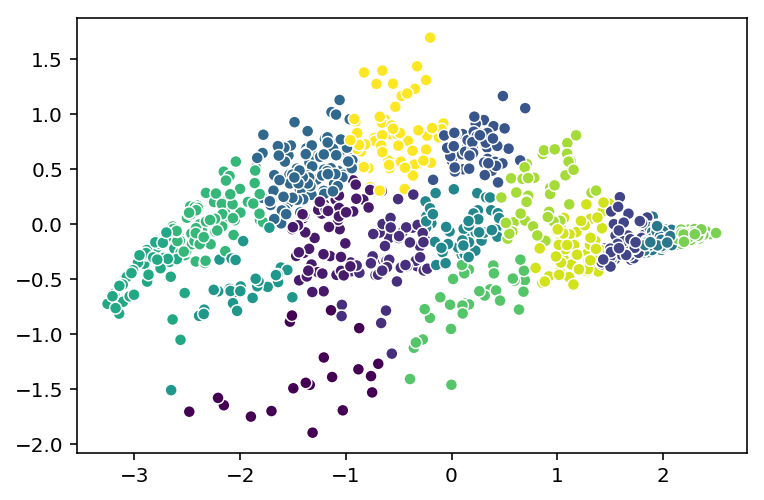

In [22]:
#reduce to 2D and plot
x1_norm,mu,sigma = feature_normalize(x1)
u1,s1 = pca(x1_norm)
z1 = project(x1_norm,u1,2)
ax=sns.scatterplot(x=z1[rand_ind,0],y=z1[rand_ind,1],hue=ind[rand_ind],legend=False,palette='viridis')